SKIQ[580468]: <INFO> libsidekiq v4.18.1 (g58be05ffb)
python3[580468]: [card-0] <INFO> Sidekiq card is serial number=7G2Y, hardware M2 C (rev C), product SKIQ-M2-002 (M.2) (part ES01420*-C0-00)
python3[580468]: [card-0] <INFO> Firmware v2.9
python3[580468]: [card-0] <INFO> Sidekiq: FPGA v3.18.1, (date 24052819, FIFO size 16k)
python3[580468]: [card-0] <INFO> Sidekiq card is configured for an internal reference clock
python3[580468]: [card-0] <INFO> Loading calibration data for Sidekiq M.2
python3[580468]: [card-0] <INFO> RF IC version 5.5.1
python3[580468]: [card-0] <INFO> Number of tx channels supported 1, number of rx channels supported 1
python3[580468]: [card-0] <INFO> Default warp voltage not currently stored (user)
[ERROR] Failure: skiq_write_rx_LO_freq (card 0, frequency 50000000)
[ERROR] Failure: skiq_read_rx_LO_freq (card 0)
[INFO] Using format CF32.
[INFO] Starting RX Sidekiq Thread
[ERROR] Failure: skiq_write_rx_LO_freq (card 0, frequency 50000000)
[ERROR] Failure: skiq_read_

Sweeping and capturing data...
Sweep complete. Plotting results with markers...


OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

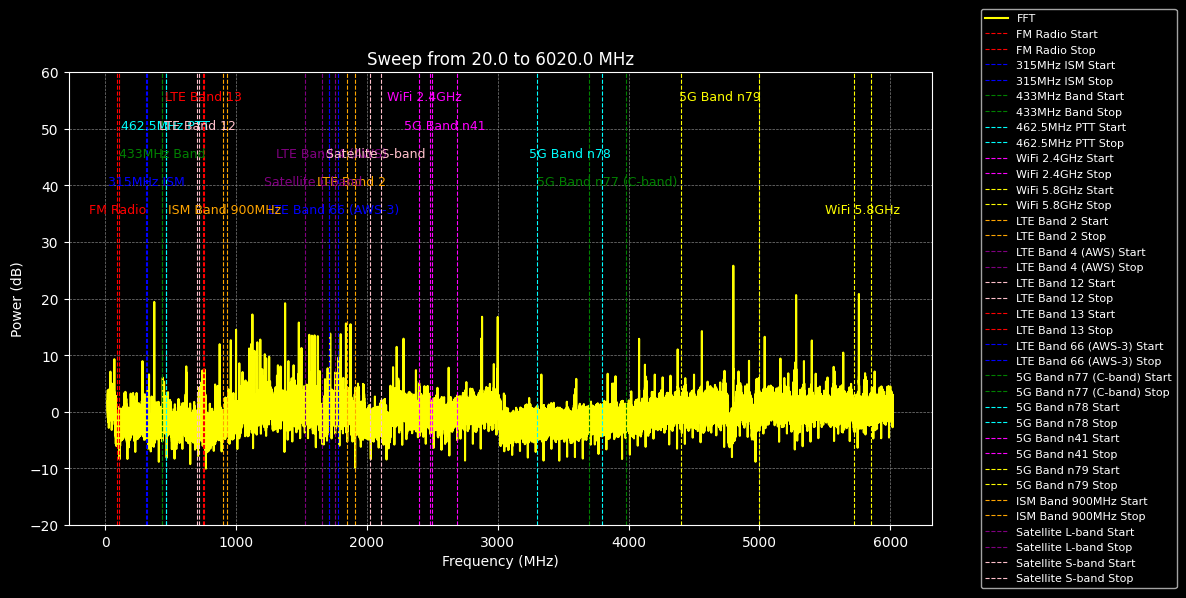

OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

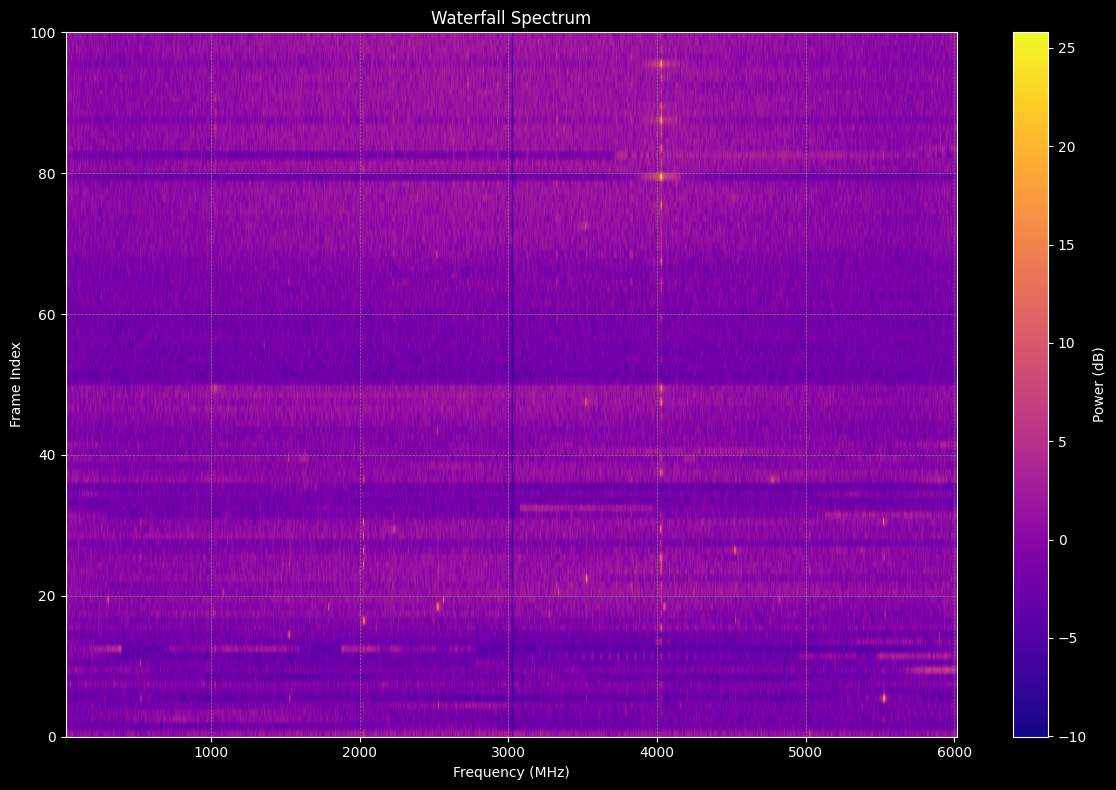

Done.


O

In [4]:
# Sweep and Stitch SDR Data Visualization

import numpy as np
import matplotlib.pyplot as plt
from sdrfly.sdr.sdr_generic import SDRGeneric
import itertools
import time

# List of colors to cycle through
colors = itertools.cycle([
    "red", "blue", "green", "cyan", "magenta", "yellow", "orange", "purple", "pink"
])

areas_of_interest = {
    "FM Radio": (87.7e6, 107.7e6),
    "315MHz ISM": (315e6, 316e6),
    "433MHz Band": (433e6, 434e6),
    "462.5MHz PTT": (462.5e6, 463.5e6),
    "WiFi 2.4GHz": (2400e6, 2483.5e6),
    "WiFi 5.8GHz": (5725e6, 5850e6),
    "LTE Band 2": (1850e6, 1910e6),
    "LTE Band 4 (AWS)": (1710e6, 1755e6),
    "LTE Band 12": (699e6, 716e6),
    "LTE Band 13": (746e6, 756e6),
    "LTE Band 66 (AWS-3)": (1710e6, 1780e6),
    "5G Band n77 (C-band)": (3700e6, 3980e6),
    "5G Band n78": (3300e6, 3800e6),
    "5G Band n41": (2496e6, 2690e6),
    "5G Band n79": (4400e6, 5000e6),
    "ISM Band 900MHz": (902e6, 928e6),
    "Satellite L-band": (1525e6, 1660.5e6),
    "Satellite S-band": (2025e6, 2110e6),
}

# Alternate positions for labels
label_y_positions = itertools.cycle([35, 40, 45, 50, 55])  # Positions for the labels in dB


# SDR Sweep Settings
START_FREQ = 50e6   # Start frequency in Hz
STOP_FREQ = 6000e6   # Stop frequency in Hz
SAMPLE_RATE = 60e6   # Sample rate in Hz
BANDWIDTH = 60e6     # Bandwidth in Hz
GAIN = 76            # Gain
SAMPLE_SIZE = 1024   # Number of samples per FFT frame
NUM_FRAMES = 20      # Number of frames per sweep step

# Instantiate SDRGeneric
sdr = SDRGeneric(
    "sidekiq",
    center_freq=START_FREQ,
    sample_rate=SAMPLE_RATE,
    bandwidth=BANDWIDTH,
    gain=GAIN,
    size=SAMPLE_SIZE
)
sdr.start()

# Receive and process data for a single frequency step
def receive_and_process_data(num_frames):
    fft_data = []
    for _ in range(num_frames):
        iq_samples = sdr.get_latest_samples()  # Receive IQ samples
        fft_frame = np.abs(np.fft.fftshift(np.fft.fft(iq_samples)))  # Compute FFT
        fft_data.append(fft_frame)
    return np.mean(fft_data, axis=0)  # Return the averaged FFT

# Perform sweep and stitch FFTs with averaging within each window
def sweep_and_stitch(start_freq, stop_freq, sample_rate):
    stitched_fft = None  # Initialize for averaging
    stitched_freqs = []  # Frequency axis for stitched FFT
    waterfall_data = []  # Waterfall data collection
    current_freq = start_freq
    num_windows = 0  # To calculate the average

    while current_freq <= stop_freq:
        # print(f"Capturing data at {current_freq / 1e6:.2f} MHz...")
        sdr.set_frequency(current_freq)
        time.sleep(0.1)
        avg_fft = receive_and_process_data(NUM_FRAMES)  # Average FFT over frames
        avg_fft_db = 20 * np.log10(avg_fft)  # Convert to dB for stitching
        waterfall_data.append(avg_fft_db)  # Append for waterfall plot

        # Frequency axis for this step
        freqs = np.linspace(
            current_freq - sample_rate / 2,
            current_freq + sample_rate / 2,
            SAMPLE_SIZE
        )

        # Stitch FFT with averaging
        if stitched_fft is None:
            stitched_fft = avg_fft
            stitched_freqs = freqs
        else:
            stitched_fft = np.concatenate((stitched_fft, avg_fft))
            stitched_freqs = np.concatenate((stitched_freqs, freqs))
        
        num_windows += 1
        current_freq += sample_rate  # Step to the next frequency

    return np.array(stitched_freqs), np.array(stitched_fft), np.array(waterfall_data)


# Plot function with different colors for each area of interest and alternating label positions
def plot_stitched_fft_and_waterfall_with_markers(freqs, fft_magnitude, waterfall_data, areas_of_interest):
    plt.style.use("dark_background")  # Enable dark mode

    # Plot stitched FFT with vertical markers
    plt.figure(figsize=(12, 6))
    plt.plot(freqs / 1e6, 20 * np.log10(fft_magnitude), label=f"FFT", color="yellow")
    plt.title(f"Sweep from {freqs[0] // 1e6} to {freqs[-1] // 1e6} MHz", color="white")
    plt.xlabel("Frequency (MHz)", color="white")
    plt.ylabel("Power (dB)", color="white")
    plt.ylim(-20, 60)  # Adjust y-axis limits to provide more space for labels

    # Mark the areas of interest with different colors
    for band_name, (start_freq, stop_freq) in areas_of_interest.items():
        color = next(colors)  # Get the next color in the cycle
        label_y_position = next(label_y_positions)  # Get the next label y-position
        plt.axvline(start_freq / 1e6, color=color, linestyle="--", linewidth=0.8, label=f"{band_name} Start")
        plt.axvline(stop_freq / 1e6, color=color, linestyle="--", linewidth=0.8, label=f"{band_name} Stop")
        mid_freq = (start_freq + stop_freq) / 2
        plt.text(
            mid_freq / 1e6,
            label_y_position,  # Alternate vertical position
            band_name,
            color=color,
            fontsize=9,
            ha="center"
        )

    plt.grid(color="gray", linestyle="--", linewidth=0.5)
    # Position the legend to the right of the plot
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=8)
    plt.tight_layout()
    plt.show()

    # Plot stitched Waterfall
    plt.figure(figsize=(12, 8))
    extent = [
        freqs[0] / 1e6, freqs[-1] / 1e6,
        0, waterfall_data.shape[0]
    ]
    plt.imshow(
        waterfall_data,
        aspect="auto",
        extent=extent,
        cmap="plasma",
        origin="lower"
    )
    plt.title("Waterfall Spectrum", color="white")
    plt.xlabel("Frequency (MHz)", color="white")
    plt.ylabel("Frame Index", color="white")
    colorbar = plt.colorbar(label="Power (dB)")
    colorbar.ax.yaxis.set_tick_params(color="white")
    plt.grid(color="gray", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("Sweeping and capturing data...")
    freqs, stitched_fft, waterfall_data = sweep_and_stitch(START_FREQ, STOP_FREQ, SAMPLE_RATE)
    print("Sweep complete. Plotting results with markers...")
    plot_stitched_fft_and_waterfall_with_markers(freqs, stitched_fft, waterfall_data, areas_of_interest)
    print("Done.")




OOOOOOOOOOOOOO

Analyzing specific areas of interest...


OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

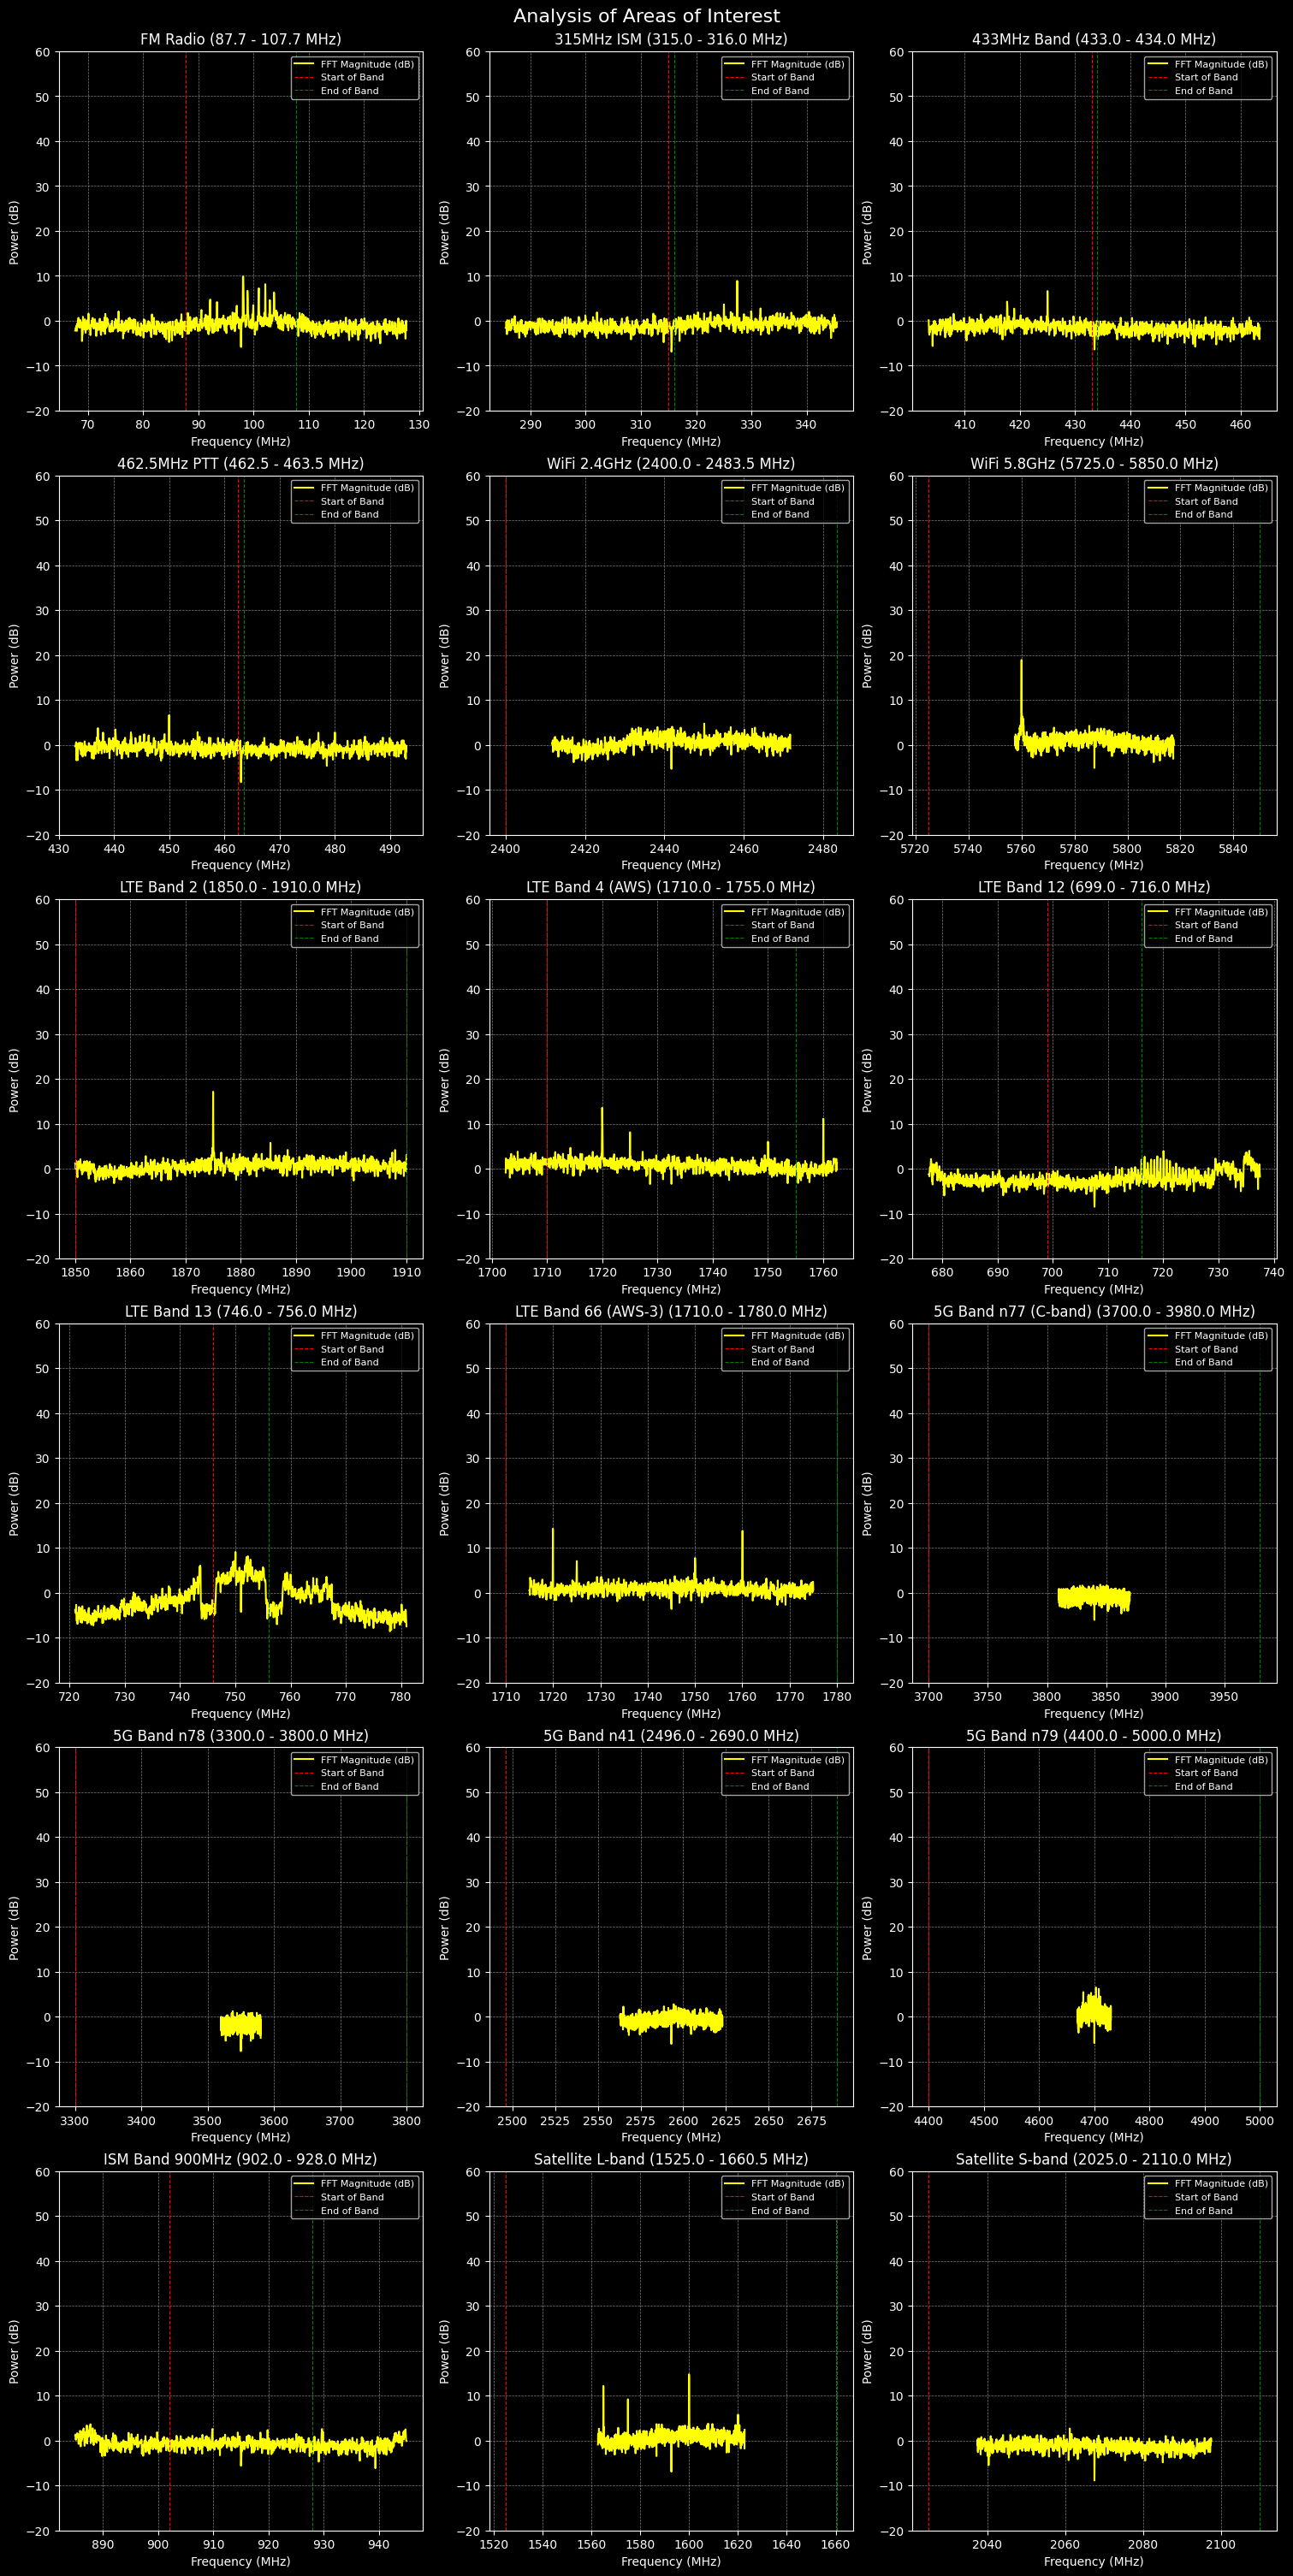

Done.


O

O

In [6]:
# New Function: Analyze and Plot Areas of Interest
def analyze_and_plot_areas_of_interest(areas_of_interest, num_frames=20, plots_per_row=3, threshold=-50):
    plt.style.use("dark_background")  # Enable dark mode
    num_areas = len(areas_of_interest)
    num_rows = (num_areas + plots_per_row - 1) // plots_per_row  # Calculate number of rows needed
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 5), constrained_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

    for i, (band_name, (start_freq, stop_freq)) in enumerate(areas_of_interest.items()):
        center_freq = (start_freq + stop_freq) / 2
        sdr.set_frequency(center_freq)  # Tune to the center frequency of the band
        time.sleep(0.1)
        avg_fft = receive_and_process_data(num_frames)  # Average FFT over frames
        avg_fft_db = 20 * np.log10(avg_fft)  # Convert to dB
        freqs = np.linspace(
            center_freq - SAMPLE_RATE / 2,
            center_freq + SAMPLE_RATE / 2,
            SAMPLE_SIZE
        )

        # Check if the signal power exceeds the threshold
        if np.max(avg_fft_db) < threshold:
            # Skip plotting if no significant signal is detected
            axes[i].annotate(
                "No detectable signal",
                xy=(0.5, 0.5),
                xycoords="axes fraction",
                ha="center",
                va="center",
                color="white",
                fontsize=10
            )
            axes[i].set_title(f"{band_name} ({start_freq/1e6:.1f} - {stop_freq/1e6:.1f} MHz)", color="white")
            axes[i].axis("off")
            continue

        ax = axes[i]  # Select the corresponding subplot
        ax.plot(freqs / 1e6, avg_fft_db, color="yellow", label="FFT Magnitude (dB)")
        ax.axvline(start_freq / 1e6, color="red", linestyle="--", linewidth=0.8, label="Start of Band")
        ax.axvline(stop_freq / 1e6, color="green", linestyle="--", linewidth=0.8, label="End of Band")
        ax.set_title(f"{band_name} ({start_freq/1e6:.1f} - {stop_freq/1e6:.1f} MHz)", color="white")
        ax.set_xlabel("Frequency (MHz)", color="white")
        ax.set_ylabel("Power (dB)", color="white")
        ax.set_ylim(-20, 20)  # Adjust y-axis limits
        ax.grid(color="gray", linestyle="--", linewidth=0.5)
        ax.legend(loc="upper right", fontsize=8)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Analysis of Areas of Interest", color="white", fontsize=16)
    plt.show()



#  Analyze and Plot Areas of Interest
if __name__ == "__main__":
    print("Analyzing specific areas of interest...")
    analyze_and_plot_areas_of_interest(areas_of_interest, num_frames=NUM_FRAMES)
    print("Done.")


In [3]:
sdr.stop()
sdr.close()

[INFO] Exiting RX Sidekiq Thread
python3[580468]: [card-0] <ERROR> At least one of the specified handles (A1) is not streaming
[ERROR] Failure: skiq_stop_rx_streaming (card 0)
python3[580468]: [card-0] <INFO> Unlocking card
